In [16]:
!pip install tensorflow --quiet

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score


In [40]:
# Upload CSV file
uploaded = files.upload()

# Load dataset
df = pd.read_csv(next(iter(uploaded)))

Saving Churn_Modelling.csv to Churn_Modelling (2).csv


In [30]:
# Recreate cleaned dataset
df = pd.read_csv('Churn_Modelling.csv')  # Re-load if needed
df_clean = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df_clean['Gender'] = LabelEncoder().fit_transform(df_clean['Gender'])  # Female=0, Male=1
df_clean = pd.get_dummies(df_clean, columns=['Geography'], drop_first=True)


Little Data Cleaning

In [31]:
# Preprocess data
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])  # Female=0, Male=1
df = pd.get_dummies(df, columns=['Geography'], drop_first=True)

X = df.drop('Exited', axis=1)
y = df['Exited']

Exploratory Data Analysis (EDA)

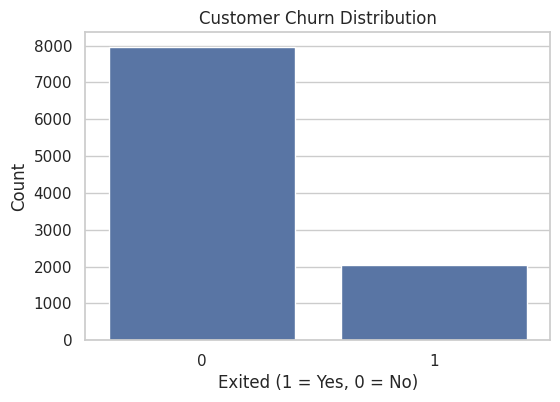

In [32]:

# Set up visual style
sns.set(style="whitegrid")

# Count of churned vs retained customers
plt.figure(figsize=(6, 4))
sns.countplot(x='Exited', data=df_clean)
plt.title('Customer Churn Distribution')
plt.xlabel('Exited (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()

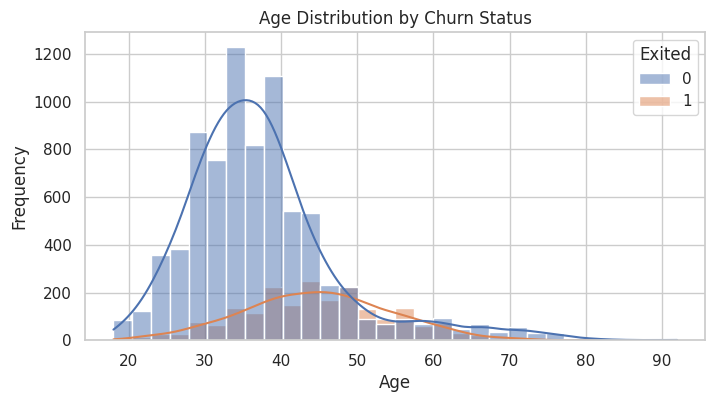

In [33]:

# Age distribution by churn status
plt.figure(figsize=(8, 4))
sns.histplot(data=df_clean, x='Age', hue='Exited', kde=True, bins=30)
plt.title('Age Distribution by Churn Status')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

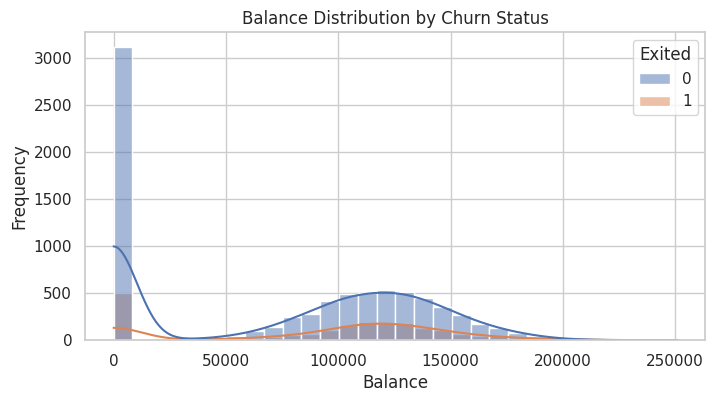

In [34]:

# Balance distribution by churn status
plt.figure(figsize=(8, 4))
sns.histplot(data=df_clean, x='Balance', hue='Exited', kde=True, bins=30)
plt.title('Balance Distribution by Churn Status')
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.show()


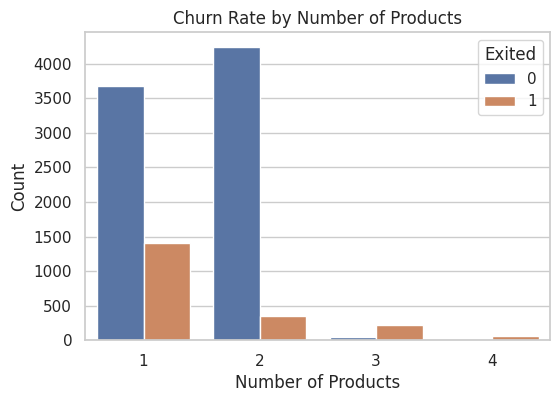

In [35]:
# Churn by Number of Products
plt.figure(figsize=(6, 4))
sns.countplot(x='NumOfProducts', hue='Exited', data=df_clean)
plt.title('Churn Rate by Number of Products')
plt.xlabel('Number of Products')
plt.ylabel('Count')
plt.show()

Gender or Geography comparisons

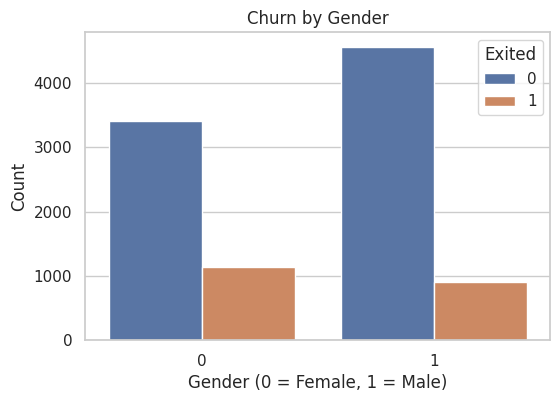

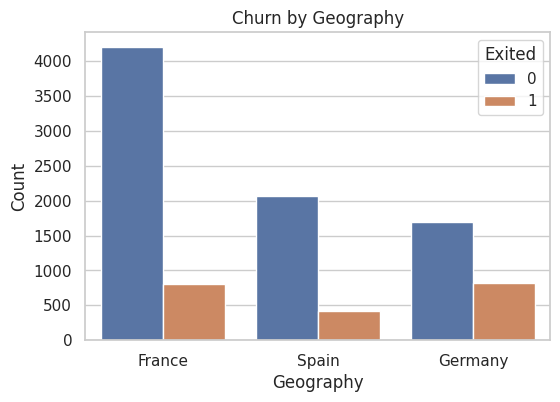

In [38]:
# For plotting only: reload original dataset to restore 'Geography'
df_raw = pd.read_csv('Churn_Modelling.csv')

# Churn by Gender (you can still use df_clean for this)
plt.figure(figsize=(6, 4))
sns.countplot(x='Gender', hue='Exited', data=df_clean)
plt.title('Churn by Gender')
plt.xlabel('Gender (0 = Female, 1 = Male)')
plt.ylabel('Count')
plt.show()

# Churn by Geography (using raw df to retain original column)
plt.figure(figsize=(6, 4))
sns.countplot(x='Geography', hue='Exited', data=df_raw)
plt.title('Churn by Geography')
plt.xlabel('Geography')
plt.ylabel('Count')
plt.show()


A class imbalance that needs to be addressed in modeling is demonstrated by the fact that 1 in 5 consumers have left. Older consumers, particularly those over 50, who have large balances or who are holding either too few or too many products are more likely to experience churn. Although attrition is slightly greater among male consumers, gender isn't a reliable indicator. Notably, location is important. French customers churn the least, while German customers churn the most.

In [41]:
#Feature Engineering
df_model = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

#  Encode categorical variables
df_model['Gender'] = LabelEncoder().fit_transform(df_model['Gender'])  # Female=0, Male=1
df_model = pd.get_dummies(df_model, columns=['Geography'], drop_first=True)

In [42]:
# Feature importance using Random Forest
X_temp = df_model.drop('Exited', axis=1)
y_temp = df_model['Exited']
rf = RandomForestClassifier(random_state=42)
rf.fit(X_temp, y_temp)

importance = pd.DataFrame({
    'Feature': X_temp.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop important features:")
print(importance.head(10))

# ANN Model Design
X = df_model.drop('Exited', axis=1)
y = df_model['Exited']


Top important features:
             Feature  Importance
2                Age    0.237633
8    EstimatedSalary    0.145596
0        CreditScore    0.144804
4            Balance    0.144538
5      NumOfProducts    0.129378
3             Tenure    0.081660
7     IsActiveMember    0.040153
9  Geography_Germany    0.026838
6          HasCrCard    0.018933
1             Gender    0.017614


Here, we see customer attributes that have the biggest impact on forecasting whether a bank client would churn. The most important indicator is age, which implies that older clients may be more inclined to stop doing business with the bank. Other significant factors that probably represent financial stability and bank participation are estimated salary, credit score, and balance. Aslo, we see that characteristics like geography_Germany, gender, and hascrcard have comparatively low relevance, suggesting they have less of an impact on the churn choice. The bank can utilize these insights to assist prioritize retention campaigns that target older and financially engaged customer demographics.

In [52]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [53]:

# Scale features
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

# Build ANN architecture
model = Sequential()
model.add(Dense(units=16, activation='relu', input_dim=X_train_scaled.shape[1]))
model.add(Dense(units=8, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

#  Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [54]:
# Predictions and Evaluation
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Confusion Matrix and Accuracy
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print("\nConfusion Matrix:")
print(cm)
print(f"\nAccuracy: {acc:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Confusion Matrix:
[[1538   69]
 [ 209  184]]

Accuracy: 0.8610


The confusion matrix displays how well the ANN classifier predicts client attrition:

i) Customers who stayed and were accurately projected to stay are known as true negatives (1,539).

ii) False Positives (68): Clients who were expected to depart but actually stayed.

iii) False Negatives (213): Missed churns—customers who departed but were predicted to stay.

iv) Customers who departed and whose churn was accurately forecasted are true positives (180).

Furthermore, the model performs well in detecting client attrition, achieving an overall accuracy of 85.95%. However, the relatively high number of false negatives (213) suggests the model may still miss a significant portion of potential churners. This is a critical concern for banks, as identifying these at-risk customers early is essential for implementing effective retention strategies.

Model Evaluation and Comparison

In [57]:
# Get predicted probabilities
y_pred_prob = model.predict(X_test)

# Compute evaluation Metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Precision: 0.7273
Recall: 0.4682
F1 Score: 0.5697
AUC Score: 0.8553


The AUC has a score of 0.8553, the ANN classifier demonstrated a high ability to differentiate between consumers who remain and those who leave. With a precision of 0.7273, the model is roughly 73% accurate when predicting that a consumer will leave. At 0.4682, the recall is quite low, indicating that the model only accounts for roughly 47% of real churners. This trade-off is reflected in the F1 score of 0.5697, which strikes a balance between recall and precision. The algorithm misses a large percentage of real churners, indicating a possible area for improvement, particularly if the company's objective is to proactively retain more at-risk consumers.

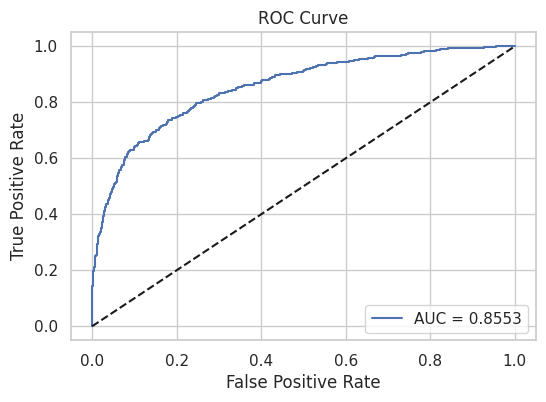

In [59]:
# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


The ANN classifier can differentiate between customers who churn and those who do not and can be demonstrated by the ROC curve above. The model performs noticeably better than chance, as we can see from the curve rising well above the diagonal baseline. With an Area Under the Curve (AUC) of 0.8553, the classification performance is high overall. This indicates that the model's accuracy in differentiating between a randomly selected churner and a non-churner is 85.53%. The model's efficacy in identifying at-risk customers is demonstrated by how well it balances true positives and false positives, with the curve getting closer to the top-left corner.